# 1.0 Clasificador

## 1.1 Generacion del modelo

### 1.1.1 Librerias y llamado de los elementos necesarios para la ejecución

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Model, load_model
from google.colab import drive
from datetime import datetime
from random import shuffle
import tensorflow as tf
import numpy as np
import warnings
import os


drive.mount('/content/drive')
warnings.filterwarnings("ignore", category=DeprecationWarning)

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Dec 17 23:18:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 1.1.2 Creación del modelo

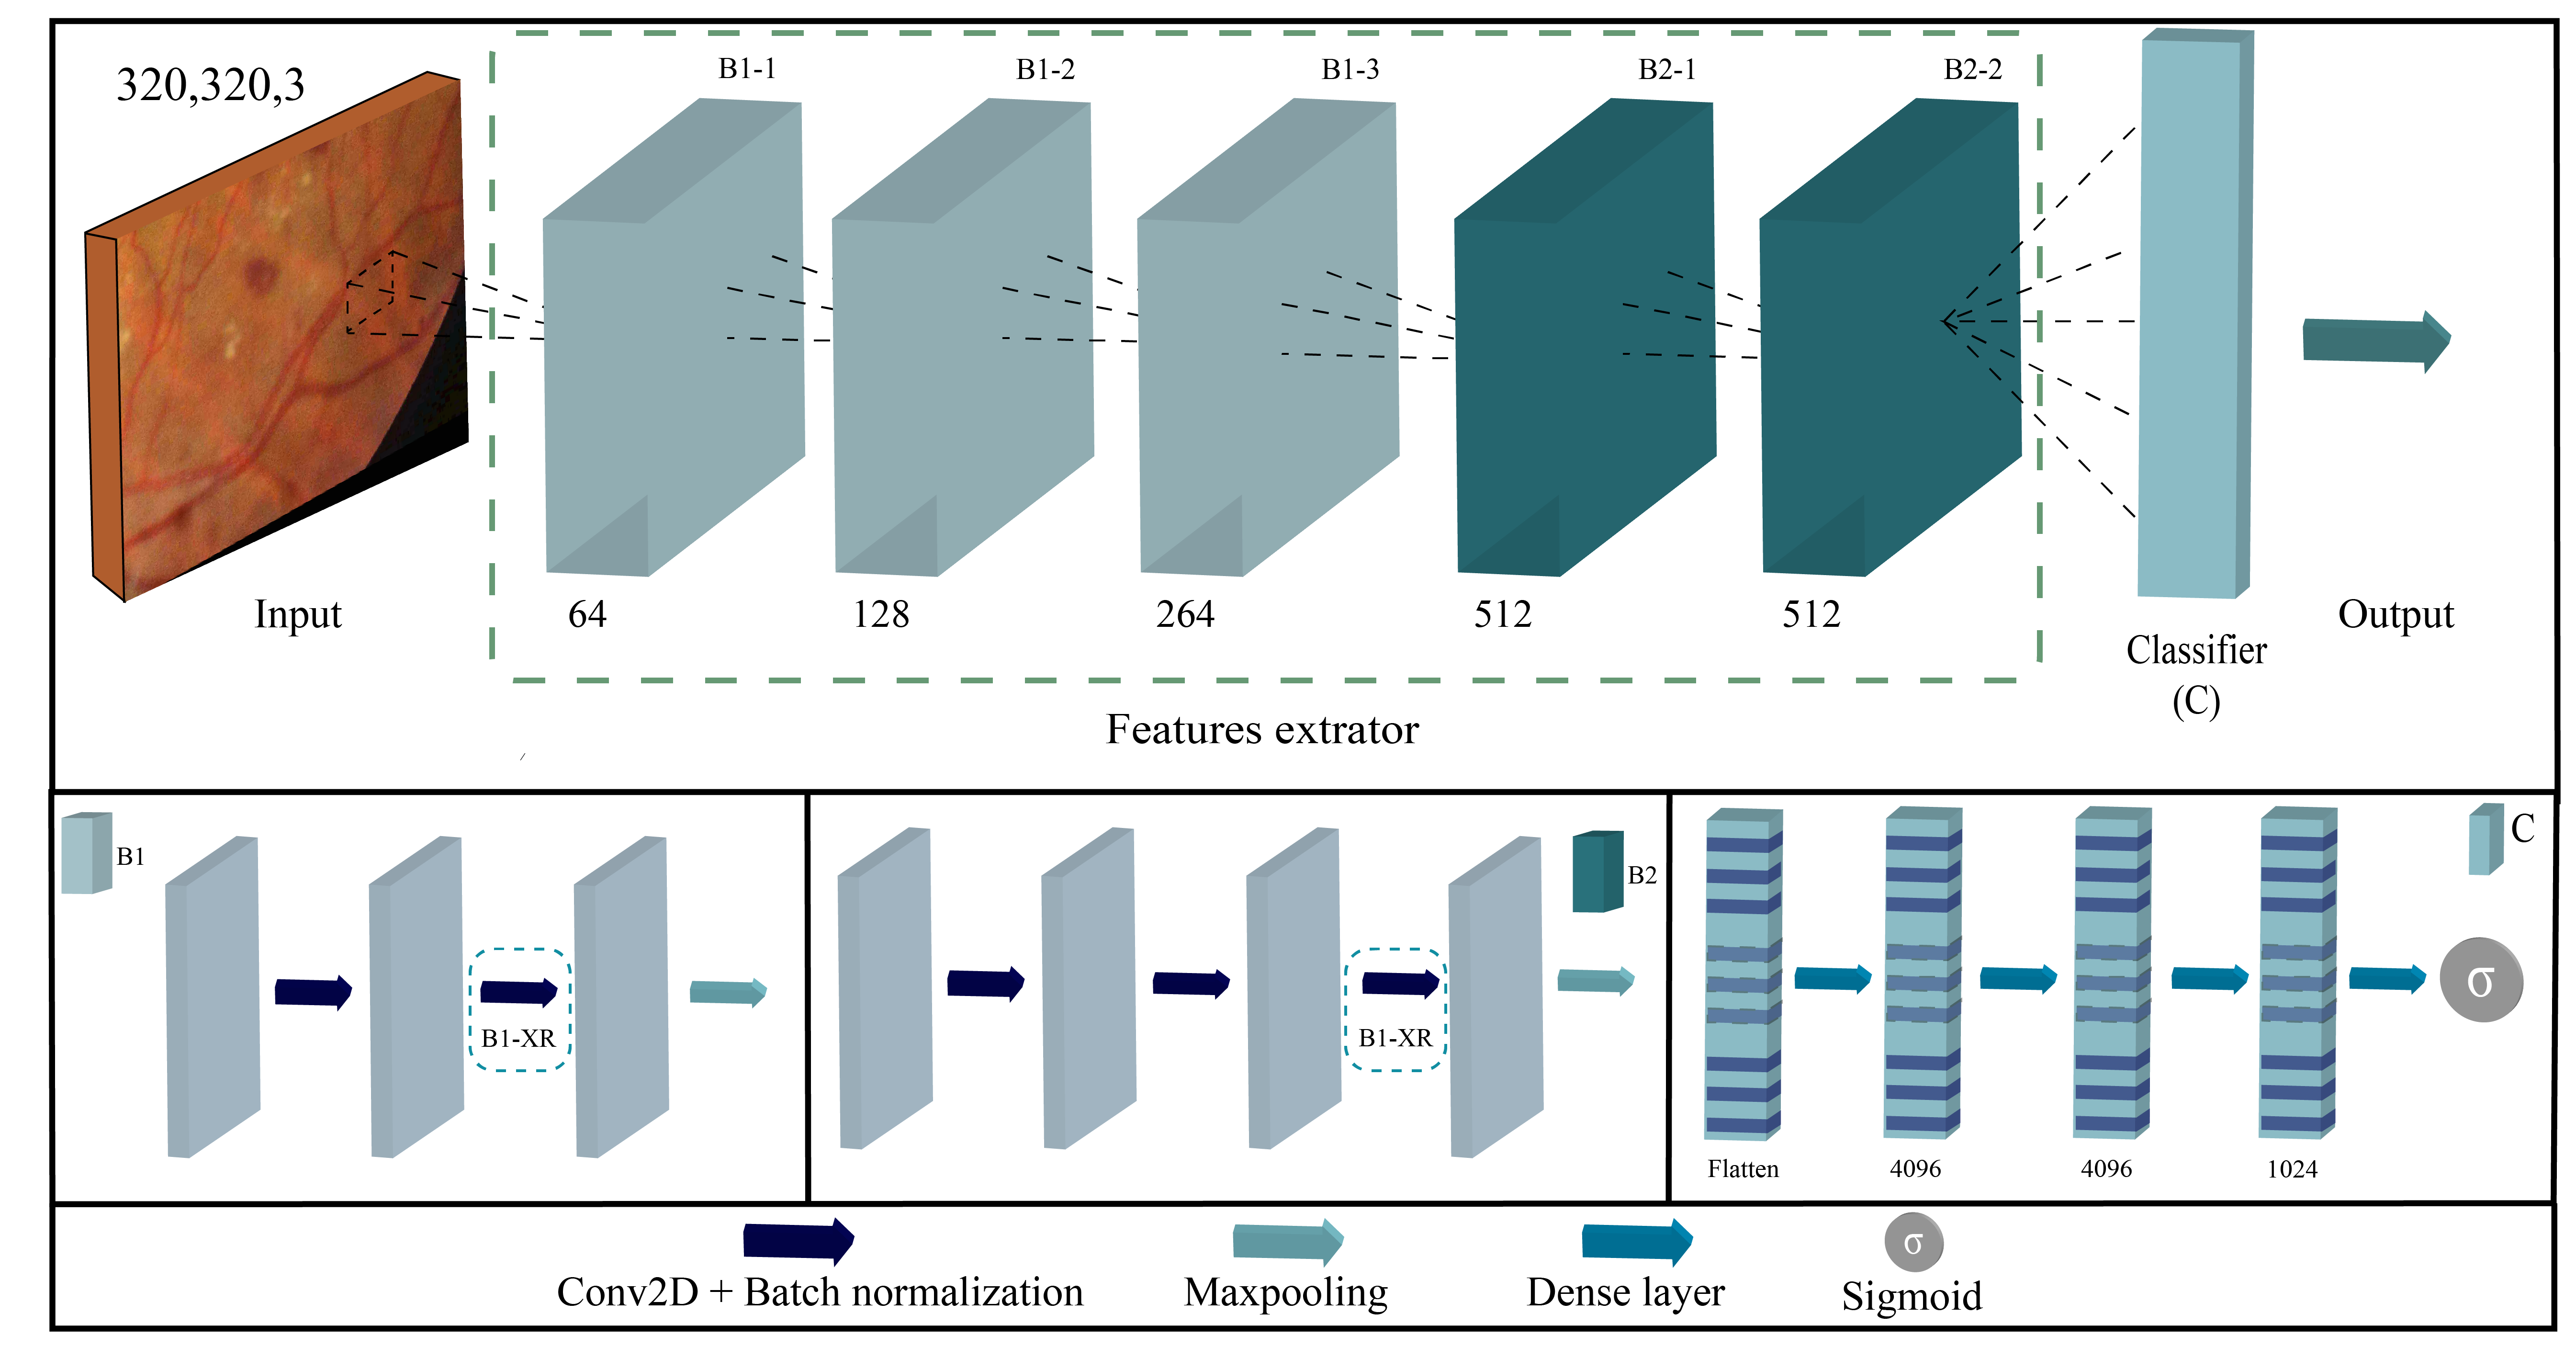

In [ ]:
def bloque_1(entrada, filtros, kernel):
  x= Conv2D(filtros, kernel, padding= 'same', activation = 'relu')(entrada)
  x= BatchNormalization()(x)
  x= Conv2D(filtros, kernel, padding= 'same', activation = 'relu')(x)
  x= BatchNormalization()(x)
  x = MaxPooling2D(3, strides = 2, padding= "same")(x)

  return x

def bloque_2(entrada, filtros, kernel, ker_reg= None):
  x= Conv2D(filtros, kernel, padding= 'same', kernel_regularizer= ker_reg, activation = 'relu')(entrada)
  x= BatchNormalization()(x)
  x= Conv2D(filtros, kernel, padding= 'same', kernel_regularizer= ker_reg, activation = 'relu')(x)
  x= BatchNormalization()(x)
  x= Conv2D(filtros, kernel, padding= 'same', kernel_regularizer= ker_reg, activation = 'relu')(x)
  x= BatchNormalization()(x)
  x = MaxPooling2D(3, strides = 2, padding= "same")(x)

  return x

def bloque_3(entrada, neuronas, ker_reg= None):
  x= Dense(neuronas, kernel_regularizer= ker_reg)(entrada)
  x= Activation('relu')(x)
  return Dropout(0.5)(x)


def channel_attention(f, filtros: int, ratio: int= 1, nombre: str= None):
  reduccion= int(filtros // ratio)
  Favr= tf.reduce_mean(f, axis= [-1], keepdims= True)
  Fmax= tf.reduce_max(f, axis=[-1], keepdims= True)

  Davr_r= Dense(reduccion, activation= 'relu')(Favr)
  Dmax_r= Dense(reduccion, activation= 'relu')(Fmax)

  Davr_a= Dense(filtros, activation= 'relu')(Davr_r)
  Dmax_a= Dense(filtros, activation= 'relu')(Dmax_r)
  
  return Activation('sigmoid', name= nombre)(tf.add(Davr_a, Dmax_a))


def spatial_attention(f, kernel_s: int= 7, nombre: str= None):
  Favr= tf.reduce_mean(f, axis= [-1], keepdims= True)
  Fmax= tf.reduce_max(f, axis= [-1], keepdims= True)

  C_am= tf.concat([Favr, Fmax], axis= -1)

  Ms= Conv2D(1, kernel_size= kernel_s, padding= 'same')(C_am)
  Ms= BatchNormalization()(Ms)

  return Activation('sigmoid', name= nombre)(Ms)


def CBAM(f, nombre: str= None):
  f_1= channel_attention(f, f.shape[-1], 16)
  r_1= tf.math.multiply(f, f_1)
  
  f_2= spatial_attention(r_1)
  r_2= tf.math.multiply(r_1, f_2)

  return tf.add(f, r_2, name= nombre)




tam_x = (480, 480, 3)
input_shape = Input(tam_x)

b1= bloque_1(input_shape, 64, 3)
b1= CBAM(b1)

b2= bloque_1(b1, 128, 3)
b2= CBAM(b2)

b3= bloque_1(b2, 256, 3)
b3= CBAM(b3)

b4= bloque_2(b3, 512, 3)#, tf.keras.regularizers.L2(0.01))
b4= CBAM(b4)

b5= bloque_2(b4, 512, 3)#, tf.keras.regularizers.L2(0.01))
b5= CBAM(b5)

si1 = Flatten()(b5)

si2 = bloque_3(si1, 4096)#, tf.keras.regularizers.L2(0.01))
si3 = bloque_3(si2, 4096)#, tf.keras.regularizers.L2(0.01))
si4 = bloque_3(si3, 1024)#, tf.keras.regularizers.L2(0.01))

si5 = Dense(1, activation= "sigmoid")(si4)

In [ ]:
model = Model(inputs = input_shape, outputs= si5)
#model.summary()

In [ ]:
#!unzip "/content/drive/MyDrive/Proyectos/Sharon/Base de datos/Base_Procesada_Mecidor/Val/Val.zip" -d "/content/sample_data/"
#!unzip "/content/drive/MyDrive/Proyectos/Sharon/Base de datos/Base_Procesada_Mecidor/Ent/Ent.zip" -d "/content/sample_data/"

#Kaggle
!unzip "/content/drive/MyDrive/Proyectos/Sharon/Base de datos/Kaggle/Val.zip" -d "/content/sample_data/"
!unzip "/content/drive/MyDrive/Proyectos/Sharon/Base de datos/Kaggle/Ent.zip" -d "/content/sample_data/"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/sample_data/Ent/S_1/5759.png  
  inflating: /content/sample_data/Ent/S_1/26891.png  
  inflating: /content/sample_data/Ent/S_1/17307.png  
  inflating: /content/sample_data/Ent/S_1/24081.png  
  inflating: /content/sample_data/Ent/S_1/37122.png  
  inflating: /content/sample_data/Ent/S_1/35773.png  
  inflating: /content/sample_data/Ent/S_1/37334.png  
  inflating: /content/sample_data/Ent/S_1/25142.png  
  inflating: /content/sample_data/Ent/S_1/33506.png  
  inflating: /content/sample_data/Ent/S_1/27224.png  
  inflating: /content/sample_data/Ent/S_1/40526.png  
  inflating: /content/sample_data/Ent/S_1/13316.png  
  inflating: /content/sample_data/Ent/S_1/5763.png  
  inflating: /content/sample_data/Ent/S_1/22714.png  
  inflating: /content/sample_data/Ent/S_1/41821.png  
  inflating: /content/sample_data/Ent/S_1/21319.png  
  inflating: /content/sample_data/Ent/S_1/7854.png  
  inflating: /content/sa

### 1.1.3 Generador para alimentar la red

In [ ]:
input_dir= "/content/sample_data/Ent"
target_dir= "/content/sample_data/Val"

generador_ent= ImageDataGenerator(rescale= 1/255.0)
generador_val= ImageDataGenerator(rescale= 1/255.0)


ent_gen= generador_ent.flow_from_directory(input_dir,
                                           class_mode= 'binary',
                                           target_size=(480, 480),
                                           batch_size= 1,
                                           color_mode= "rgb",
                                           shuffle= True,
                                           )

val_gen= generador_val.flow_from_directory(target_dir,
                                           class_mode= 'binary',
                                           target_size=(480, 480),
                                           color_mode= "rgb",
                                           batch_size= 1,
                                           shuffle= True,
                                           )

Found 58634 images belonging to 2 classes.
Found 6515 images belonging to 2 classes.


## 1.2 Entrenamiento del modelo

### 1.2.1 Funciones para la ejecucion del entrenamiento y cargar algun modelo guardado

In [ ]:
def entrenamient_modelo(train_gen, val_gen, DIR_save, epocas= 30):

    #Generamos los callback necesarios
    #class_weights= {0: 1., 1: 3.}
    checkpoint= ModelCheckpoint(DIR_save+ "04122021_CBAM.hdf5", monitor= 'val_loss', save_best_only= True, mode= 'min', save_weights_only= False)
    reduceLROnPlat= ReduceLROnPlateau(monitor= 'val_loss', factor= 0.8, patience= 15, min_delta= 0.001, cooldown= 10, min_lr= 0.00001)
    tensorboard_callback = TensorBoard(log_dir= datetime.now().strftime("%Y%m%d-%H%M%S"))
    callbacks= [EarlyStopping(patience= 30,  monitor='val_loss'), checkpoint, tensorboard_callback, reduceLROnPlat]
    metrica= [tf.keras.metrics.AUC(),
              tf.keras.metrics.BinaryAccuracy(),
              tf.keras.metrics.Recall(),
              tf.keras.metrics.Precision()]

    #Compilamos con la funcion perdida y el optimizador que utilizaremos
    #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.0001), loss = 'binary_crossentropy', metrics= metrica)
    history= model.fit(train_gen, batch_size= 1, epochs=epocas, validation_data=val_gen, callbacks=callbacks)#, class_weight= class_weights)

def carga_mod(DIR):
    return tf.keras.models.load_model(DIR)

### 1.2.2 Directorios para guardar o cargar el modelo y llamado al entrenamiento

In [ ]:
DIR_save_best= '/content/drive/MyDrive/Proyectos/Sharon/Modelos guardados/VGG16/Kaggle/'
DIR_load_best= '/content/drive/MyDrive/Proyectos/Sharon/Modelos guardados/VGG16/Mesidor/30112021_CBAM.hdf5'

model= carga_mod(DIR_load_best)
entrenamient_modelo(ent_gen, val_gen, DIR_save_best, 300)

Epoch 1/300
58634/58634 [==============================] - 7197s 123ms/step - loss: 0.6273 - auc: 0.5706 - binary_accuracy: 0.6432 - recall: 0.9989 - precision: 0.6435 - val_loss: 0.5775 - val_auc: 0.6575 - val_binary_accuracy: 0.6434 - val_recall: 1.0000 - val_precision: 0.6434 - lr: 1.0000e-04
Epoch 2/300
58634/58634 [==============================] - 7125s 122ms/step - loss: 0.4901 - auc: 0.8112 - binary_accuracy: 0.7078 - recall: 0.8747 - precision: 0.7268 - val_loss: 3.1213 - val_auc: 0.7742 - val_binary_accuracy: 0.7365 - val_recall: 0.8984 - val_precision: 0.7447 - lr: 1.0000e-04
Epoch 3/300
58634/58634 [==============================] - 7125s 122ms/step - loss: 0.4204 - auc: 0.8713 - binary_accuracy: 0.8037 - recall: 0.7552 - precision: 0.9261 - val_loss: 1.5134 - val_auc: 0.7898 - val_binary_accuracy: 0.6760 - val_recall: 0.5828 - val_precision: 0.8709 - lr: 1.0000e-04
Epoch 4/300
58634/58634 [==============================] - 7145s 122ms/step - loss: 0.4168 - auc: 0.8766 - bi

KeyboardInterrupt: ignored

## 1.3 Analizis de resultados

### 1.3.1 Grad-Cam

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from IPython.display import Image, display
import matplotlib.pyplot as plt
from google.colab import drive
import matplotlib.cm as cm
import tensorflow as tf
import numpy as np
import warnings


#drive.mount('/content/drive')
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
DIR_load_best= '/content/drive/MyDrive/Proyectos/Sharon/Modelos guardados/VGG16/320/13102021_ADAM_3.hdf5'
model= tf.keras.models.load_model(DIR_load_best)
#model.summary()

In [ ]:
def obtener_tensor(DIR_img, tam):
  # Acondicionamiento de la imagen para entrar al modelo como tensor
  # ejemplo: (1, 320, 320, 3)
  img= tf.keras.preprocessing.image.load_img(DIR_img, target_size= tam)
  array= tf.keras.preprocessing.image.img_to_array(img)
  array= np.expand_dims(array, axis= 0)
  return array

def realizar_gradcam_heatmap(arr_img, model, nombre_uc, most= False, pred_index= None):
  # Se genera el modelo donde se obtendra la salida para el heatmap
  modelo_grad= tf.keras.models.Model(
      [model.inputs], [model.get_layer(nombre_uc).output, model.output]
  )

  #Se genera una salida del modelo creado anteriormente
  with tf.GradientTape() as tape:
    salida_uc, preds= modelo_grad(arr_img)
    if pred_index is None:
      pred_index= tf.argmax(preds[0])
    canal_cl= preds[:, pred_index]


  grads= tape.gradient(canal_cl, salida_uc)

  conct_grads= tf.reduce_mean(grads, axis= (0, 1, 2))

  salida_uc = salida_uc[0]
  heatmap = salida_uc @ conct_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

  if most== True:
    plt.matshow(np.uint8(255* heatmap))
    plt.show()
  return heatmap.numpy()

def mostrar_img_heatmap(heatmap, DIR_img, tam, fact= 0.4, mostrar= False, DIR_sav= ""):
  heatmap= np.uint8(255* heatmap)
  img_1= tf.keras.preprocessing.image.load_img(DIR_img, target_size= tam)
  img= tf.keras.preprocessing.image.img_to_array(img_1)
  jet= cm.get_cmap("jet")

  jet_colors= jet(np.arange(256))[:, :3]
  jet_heatmap= jet_colors[heatmap]

  jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

  superimposed_img = jet_heatmap * fact + img
  superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

  if mostrar== True:
    superimposed_img.save(DIR_sav)
    display(superimposed_img)

  return superimposed_img, img_1

def Cuadro_comparativo(heatmaps, img):
  tma= len(heatmaps)
  fig, ax = plt.subplots(2, tma)
  for f in range(tma):
    ax[0, f].axis("off")
    ax[0, f].imshow(heatmaps[f])
    ax[1, f].axis("off")
    ax[1, f].imshow(img[f])

  fig.tight_layout()
  plt.show()

In [ ]:
# Imagenes que se van a mostrar 83, 532

img_path_1= "/content/drive/MyDrive/Proyectos/Sharon/Base de datos/binario_normal/Validacion/1/4881.png"
img_1= obtener_tensor(img_path_1, (320, 320))/255.0

img_path_2= "/content/drive/MyDrive/Proyectos/Sharon/Base de datos/binario_normal/Validacion/1/4853.png"
img_2= obtener_tensor(img_path_2, (320, 320))/255.0

img_path_3= "/content/drive/MyDrive/Proyectos/Sharon/Base de datos/binario_normal/Validacion/1/4830.png"
img_3= obtener_tensor(img_path_3, (320, 320))/255.0

img_path_4= "/content/drive/MyDrive/Proyectos/Sharon/Base de datos/binario_normal/Validacion/1/5048.png"
img_4= obtener_tensor(img_path_4, (320, 320))/255.0
#display(Image(img_path))

# Capa que se va a utilizar para el Grad-Cam, por lo regular es la ultima antes del clasificador
nombre_uc= "conv2d_11"

#Mandamos obtener el heatmap de la imagen obtenida
heatmap_1= realizar_gradcam_heatmap(img_1, model, nombre_uc)
h_1, i_1= mostrar_img_heatmap(heatmap_1, img_path_1, (320,320), 0.4, True, "/content/drive/MyDrive/Proyectos/Sharon/0.png")

heatmap_2= realizar_gradcam_heatmap(img_2, model, nombre_uc)
h_2, i_2= mostrar_img_heatmap(heatmap_2, img_path_2, (320,320), 0.4, True, "/content/drive/MyDrive/Proyectos/Sharon/1.png")

heatmap_3= realizar_gradcam_heatmap(img_3, model, nombre_uc)
h_3, i_3= mostrar_img_heatmap(heatmap_3, img_path_3, (320,320), 0.4, True, "/content/drive/MyDrive/Proyectos/Sharon/2.png")

heatmap_4= realizar_gradcam_heatmap(img_4, model, nombre_uc)
h_4, i_4= mostrar_img_heatmap(heatmap_4, img_path_4, (320,320), 0.4, True, "/content/drive/MyDrive/Proyectos/Sharon/3.png")


#Cuadro_comparativo([h_1, h_2, h_3, h_4], [i_1, i_2, i_3, i_4])

# 2.0 Segmentación de lesiones

##2.1 Generación del modelo

###2.1.1 Importando librerias

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Conv2DTranspose, MaxPooling2D, UpSampling2D, concatenate, Dropout, Input, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import drive
import os
import tensorflow as tf
import numpy as np
import warnings


#drive.mount('/content/drive')
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
print("Los dispositivos encontrados son: ", gpus)
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "GPUs físicos,", len(logical_gpus), "GPUs lógicos")
  except RuntimeError as e:
    print(e)
print("----------------------------------------------------- \n")

Los dispositivos encontrados son:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 GPUs físicos, 1 GPUs lógicos
----------------------------------------------------- 



###2.1.2 Creación del modelo

In [ ]:
# Dirección del modelo y carga del modelo
model_path= '/content/drive/MyDrive/Proyectos/Sharon/Modelos guardados/VGG16/Kaggle/04122021_CBAM.hdf5'

model_2= tf.keras.models.load_model(model_path)
#model_2.summary()

In [ ]:
def bloque_1(entrada, filtros, kernel):
  x= Conv2D(filtros, kernel, padding= 'same', activation = 'relu')(entrada)
  x= BatchNormalization()(x)
  x= Conv2D(filtros, kernel, padding= 'same', activation = 'relu')(x)
  x= BatchNormalization()(x)
  x = MaxPooling2D(3, strides = 2, padding= "same")(x)

  return x

def bloque_2(entrada, filtros, kernel, ker_reg= None):
  x= Conv2D(filtros, kernel, padding= 'same', kernel_regularizer= ker_reg, activation = 'relu')(entrada)
  x= BatchNormalization()(x)
  x= Conv2D(filtros, kernel, padding= 'same', kernel_regularizer= ker_reg, activation = 'relu')(x)
  x= BatchNormalization()(x)
  x= Conv2D(filtros, kernel, padding= 'same', kernel_regularizer= ker_reg, activation = 'relu')(x)
  x= BatchNormalization()(x)
  x = MaxPooling2D(3, strides = 2, padding= "same")(x)

  return x

def bloque_3(entrada, neuronas, ker_reg= None):
  x= Dense(neuronas, kernel_regularizer= ker_reg)(entrada)
  x= Activation('relu')(x)
  return Dropout(0.5)(x)


def channel_attention(f, filtros: int, ratio: int= 1, nombre: str= None):
  reduccion= int(filtros // ratio)
  Favr= tf.reduce_mean(f, axis= [-1], keepdims= True)
  Fmax= tf.reduce_max(f, axis=[-1], keepdims= True)

  Davr_r= Dense(reduccion, activation= 'relu')(Favr)
  Dmax_r= Dense(reduccion, activation= 'relu')(Fmax)

  Davr_a= Dense(filtros, activation= 'relu')(Davr_r)
  Dmax_a= Dense(filtros, activation= 'relu')(Dmax_r)
  
  return Activation('sigmoid', name= nombre)(tf.add(Davr_a, Dmax_a))


def spatial_attention(f, kernel_s: int= 7, nombre: str= None):
  Favr= tf.reduce_mean(f, axis= [-1], keepdims= True)
  Fmax= tf.reduce_max(f, axis= [-1], keepdims= True)

  C_am= tf.concat([Favr, Fmax], axis= -1)

  Ms= Conv2D(1, kernel_size= kernel_s, padding= 'same')(C_am)
  Ms= BatchNormalization()(Ms)

  return Activation('sigmoid', name= nombre)(Ms)


def CBAM(f, nombre: str= None):
  f_1= channel_attention(f, f.shape[-1], 16)
  r_1= tf.math.multiply(f, f_1)
  
  f_2= spatial_attention(r_1)
  r_2= tf.math.multiply(r_1, f_2)

  return tf.add(f, r_2, name= nombre)




tam_x = (160, 160, 3)
input_shape = Input(tam_x)

b1= bloque_1(input_shape, 64, 3)
b1= CBAM(b1)

b2= bloque_1(b1, 128, 3)
b2= CBAM(b2)

b3= bloque_1(b2, 256, 3)
b3= CBAM(b3)

b4= bloque_2(b3, 512, 3)#, tf.keras.regularizers.L2(0.01))
b4= CBAM(b4)

b5= bloque_2(b4, 512, 3)#, tf.keras.regularizers.L2(0.01))
b5= CBAM(b5)

model_1 = Model(inputs = input_shape, outputs= b5)
#model_1.summary()

In [ ]:
for i, capa in enumerate(model_2.layers):
  #print(i)
  #print(capa)
  if i < 115:
    model_1.layers[i].set_weights= capa.weights

In [ ]:
def congelar_capas(model1):
  for layer in model1.layers:
    layer.trainable= True
  return model1

def cop_crong(modelo_ant, dir_a):
  x= modelo_1.get_layer(dir_a)
  return x.output

def up_conc(capa, res):
  x= UpSampling2D(2)(capa)
  return concatenate([x, res])

def conv_f(ker, x, nm):
  x= Conv2D(ker, 3, padding= "same", activation= "relu", name= 'conv2d_'+ str(nm))(x)
  x= BatchNormalization(name= 'batch_normalization_'+ str(nm))(x)
  x= Conv2D(ker, 3, padding= "same", activation= "relu", name= 'conv2d_'+ str(nm+1))(x)
  x= BatchNormalization(name= 'batch_normalization_'+ str(nm+1))(x)
  return Conv2DTranspose(int(ker/2), 3, padding= "same")(x)

def conv_v(ker, x, nm):
  x= Conv2D(ker, 3, padding= "same", activation= "relu", name= 'conv2d_'+ str(nm))(x)
  x= BatchNormalization(name= 'batch_normalization_'+ str(nm))(x)
  x= Conv2D(ker, 3, padding= "same", activation= "relu", name= 'conv2d_'+ str(nm+1))(x)
  x= BatchNormalization(name= 'batch_normalization_'+ str(nm+1))(x)
  x= Conv2D(ker, 3, padding= "same", activation= "relu", name= 'conv2d_'+ str(nm+2))(x)
  x= BatchNormalization(name= 'batch_normalization_'+ str(nm+2))(x)
  return Conv2DTranspose(int(ker/2), 3, padding= "same")(x)

def salida_d(ker, x, nm):
  x= Conv2D(ker, 3, padding= "same", activation= "relu", name= 'conv2d_'+ str(nm))(x)
  x= BatchNormalization(name= 'batch_normalization_'+ str(nm))(x)
  x= Conv2D(ker/2, 3, padding= "same", activation= "relu", name= 'conv2d_'+ str(nm+1))(x)
  x= BatchNormalization(name= 'batch_normalization_'+ str(nm+1))(x)
  return Conv2D(2, 3, padding= "same", activation= "softmax", name= 'conv2d_'+ str(nm+2))(x)

In [ ]:
#model_1= Model(inputs= model.inputs, outputs= model.layers[33].output)
modelo_1= congelar_capas(model_1)

x1= cop_crong(model_1, 'batch_normalization_4')
x2= cop_crong(model_1, 'batch_normalization_7')
x3= cop_crong(model_1, 'batch_normalization_11')
x4= cop_crong(model_1, 'batch_normalization_15')
x5= cop_crong(model_1, 'tf.math.add_19')

x5= conv_v(1024, x5, 17)
x6= up_conc(x5, x4)


x7= conv_v(1024, x6, 20)
x8= up_conc(x7, x3)

x9= conv_f(512, x8, 24)
x10= up_conc(x9, x2)


x11= conv_f(256, x10, 26)
x12= up_conc(x11, x1)

x13= conv_f(128, x12, 28)
x14= UpSampling2D(2)(x13)

x15= salida_d(64, x14, 30)


new_model= Model(inputs= model_1.input, outputs= x15)

new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 160, 160, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                           

##2.2 Preparacion de los datos

###2.2.1 LLamado de los datos para entrenar

In [ ]:
!unzip "/content/drive/MyDrive/Proyectos/Sharon/Base de datos/Segmentacion/Hem/Val.zip" -d "/content/sample_data/"
!unzip "/content/drive/MyDrive/Proyectos/Sharon/Base de datos/Segmentacion/Hem/Ent.zip" -d "/content/sample_data/"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/sample_data/Ent/mask/151765.png  
  inflating: /content/sample_data/Ent/mask/93443.png  
  inflating: /content/sample_data/Ent/mask/143207.png  
  inflating: /content/sample_data/Ent/mask/233997.png  
  inflating: /content/sample_data/Ent/mask/168964.png  
  inflating: /content/sample_data/Ent/mask/107199.png  
  inflating: /content/sample_data/Ent/mask/119602.png  
  inflating: /content/sample_data/Ent/mask/90501.png  
  inflating: /content/sample_data/Ent/mask/72507.png  
  inflating: /content/sample_data/Ent/mask/40467.png  
  inflating: /content/sample_data/Ent/mask/12688.png  
  inflating: /content/sample_data/Ent/mask/119534.png  
  inflating: /content/sample_data/Ent/mask/203575.png  
  inflating: /content/sample_data/Ent/mask/207901.png  
  inflating: /content/sample_data/Ent/mask/90261.png  
  inflating: /content/sample_data/Ent/mask/49045.png  
  inflating: /content/sample_data/Ent/mask/150267.

In [ ]:
ent_input_dir= "/content/sample_data/Ent/org"
ent_target_dir= "/content/sample_data/Ent/mask"

val_input_dir= "/content/sample_data/Val/org"
val_target_dir= "/content/sample_data/Val/mask"

input_img_paths = sorted(
    [
        os.path.join(ent_input_dir, fname)
        for fname in os.listdir(ent_input_dir) 
        if fname.endswith(".png")
    ]
)

target_img_paths = sorted(
    [
        os.path.join(ent_target_dir, fname)
        for fname in os.listdir(ent_target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

val_input_paths = sorted(
    [
        os.path.join(val_input_dir, fname)
        for fname in os.listdir(val_input_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

val_target_paths = sorted(
    [
        os.path.join(val_target_dir, fname)
        for fname in os.listdir(val_target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

ID_input_t= np.arange(len(input_img_paths))
ID_input_v= np.arange(len(val_input_paths))

print(len(input_img_paths))
print(len(target_img_paths))
print(len(val_target_paths))
print(len(val_input_paths))

22025
22025
2447
2447


###2.2.1 Generador para los datos de segmentación

In [ ]:
#Generador de los ejemplos de entrada
class MiClasificacion(tf.keras.utils.Sequence):
    def __init__(self, input_img_paths, target_img_paths, ID_input, batch_size= 32, img_size= (304, 304, 3), train= True):

        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.ID_input = ID_input
        self.cont= 0

    def __len__(self):
        # Calcula el numero de pasos por epoca.
        return len(self.ID_input) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""

        # Combinamos los datos en cada epoca, pero solo para los datos de entrenamiento
        if (self.cont== len(self.ID_input) // self.batch_size) or (self.cont== 0):
            np.random.shuffle(self.ID_input)
            self.cont= 0
            
        i = idx * self.batch_size
        batch_img= []
        batch_tar= []
        self.cont += 1

        #De acuerdo a los indices en ID_input tomamos las imagenes de los paths correspondientes
        for ig in self.ID_input[i : i + self.batch_size]:
            batch_img.append(self.input_img_paths[ig])
            batch_tar.append(self.target_img_paths[ig])

        X, Y= self.__data_generation(batch_img, batch_tar)                                          # Mandamos llamar a la funcion generadora de los ejemplos
        
        
        #print(X.shape)
        #print(Y.shape)
        return X, Y

    def __data_generation(self, biip, btip):
            
        # Creacion del tensor con dimensiones las dimensiones de entrada
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")                   # Generamos un tensor que almacenara las imagenes importadas     
        for j, path in enumerate(biip):
            img = load_img(path, target_size=self.img_size)                                         # Cragamos las imagenes de entrada 
            x[j] = np.array(img)/255.0                                                              # Normalizamos y agregamos la imagen al tensor

        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")                      # Generamos un tensor que almacenara las mascaras importadas 
        for j, path in enumerate(btip):
            img = load_img(path,target_size= self.img_size,color_mode="grayscale")                  # Importamos la imagne en escala de grises
            y[j] = np.expand_dims(img, 2)
            for r in range(y.shape[1]):
                for g in range(y.shape[2]):
                    if y[j, r, g, 0]!= 0:                                                           # Nos aseguramos de que las venas etiquetadas resulten se un 1
                        y[j, r, g, 0]= 1

        return x, y

##2.3 Entrenamiento del modelo de segmentación

In [ ]:
def entrenamient_modelo(train_gen, val_gen, DIR_save, epocas= 30):

    #Generamos los callback necesarios
    checkpoint= ModelCheckpoint(DIR_save+ "05122021_H_CBAM.hdf5", monitor= 'val_loss', save_best_only= True, mode= 'min', save_weights_only= False)
    #reduceLROnPlat= ReduceLROnPlateau(monitor= 'val_loss', factor= 0.8, patience= 5, min_delta= 0.001, cooldown= 10, min_lr= 0.0001)
    #tensorboard_callback = TensorBoard(log_dir= datetime.now().strftime("%Y%m%d-%H%M%S"))
    callbacks= [EarlyStopping(patience= 12,  monitor='val_loss'), History(), checkpoint]#, reduceLROnPlat, tensorboard_callback]

    #Compilamos con la funcion perdida y el optimizador que utilizaremos
    new_model.compile(optimizer="Adam", loss= "sparse_categorical_crossentropy", metrics= ['accuracy']) #loss= "binary_crossentropy", metrics= ['accuracy'])
    history= new_model.fit(train_gen, epochs=epocas, validation_data=val_gen, callbacks=callbacks)

def carga_mod(DIR):
    return tf.keras.models.load_model(DIR)



img_size = (160, 160)
num_classes = 2; batch_size_t = 16; batch_size_v = 16

#Creamos los generadoras para el entrenamiento y la validación
train_gen = MiClasificacion(
    input_img_paths, target_img_paths, ID_input_t, batch_size= batch_size_t, img_size= img_size
)

val_gen = MiClasificacion(
    val_input_paths, val_target_paths, ID_input_v, batch_size=batch_size_v, img_size= img_size
)


DIR_save_best= '/content/drive/MyDrive/Proyectos/Sharon/Modelos guardados/Segmentacion/'
#DIR_best= '/content/drive/MyDrive/Proyectos/Sharon/Modelos guardados/VGG16/Kaggle/04122021_CBAM.hdf5'

#new_model= carga_mod(DIR_best)
entrenamient_modelo(train_gen, val_gen, DIR_save_best, 15)

Epoch 1/15
1376/1376 [==============================] - 1093s 778ms/step - loss: 0.2575 - accuracy: 0.9391 - val_loss: 0.2307 - val_accuracy: 0.9188
Epoch 2/15
1376/1376 [==============================] - 1035s 752ms/step - loss: 0.2210 - accuracy: 0.9467 - val_loss: 0.2909 - val_accuracy: 0.9756
Epoch 3/15
1376/1376 [==============================] - 1029s 747ms/step - loss: 0.2172 - accuracy: 0.9458 - val_loss: 0.2414 - val_accuracy: 0.9697
Epoch 4/15
1376/1376 [==============================] - 1033s 751ms/step - loss: 0.2140 - accuracy: 0.9443 - val_loss: 0.2255 - val_accuracy: 0.9863
Epoch 5/15
1376/1376 [==============================] - 1035s 752ms/step - loss: 0.2097 - accuracy: 0.9439 - val_loss: 0.3040 - val_accuracy: 0.8106
Epoch 6/15
1376/1376 [==============================] - 1032s 750ms/step - loss: 0.2092 - accuracy: 0.9443 - val_loss: 0.2052 - val_accuracy: 0.9491
Epoch 7/15
1376/1376 [==============================] - 1032s 749ms/step - loss: 0.2044 - accuracy: 0.9447

KeyboardInterrupt: ignored

##2.4 Analisis de resultados

###2.4.1 Librerias para el analisis

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import ImageOps
import tensorflow as tf
import numpy as np
import cv2 as cv
#from IPython.display import Image, display
import PIL


drive.mount('/content/drive')

Mounted at /content/drive


###2.4.2 Predicción de los datos

In [ ]:
DIR= '/content/drive/MyDrive/Proyectos/Sharon/Modelos guardados/Segmentacion/05122021_H_CBAM.hdf5'
model= tf.keras.models.load_model(DIR)

In [ ]:
def cambio_tam(img, msk):
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

  gray = cv.GaussianBlur(gray, (7, 7), 3)
  t, dst = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_TRIANGLE)
  contours, _= cv.findContours(dst, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  a = []

  for c in contours:
    area = cv.contourArea(c)
    a.append(area)
        
  for f in contours:
    area = cv.contourArea(f)
    if area == max(a):
      x, y, w, h = cv.boundingRect(f)
      imgr = img[y:y + h, x:x + w]
      mask = msk[y:y + h, x:x + w]

  return imgr, mask

def prediccion_m(model, img, mostrar= False, h=0):
  img= (np.array(img).reshape(-1,160,160,3))/255.0
  val_preds = model.predict(img)
  mask = np.argmax(val_preds[0], axis=-1)
  mask = np.expand_dims(mask, axis=-1)
  img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(mask))
  if mostrar== True:
    plt.imshow(img, cmap="gray")
    plt.show()
  return img

def equalize_clahe_color(img):
    cla = cv.createCLAHE(clipLimit=1.5)     
    channels = cv.split(img)     
    eq_channels = []
    for ch in channels:         
        eq_channels.append(cla.apply(ch))     
        eq_image = cv.merge(eq_channels)     
    return eq_image

def pre_procesamiento(img):
    return cv.cvtColor(equalize_clahe_color(cv.cvtColor(img, cv.COLOR_BGR2RGB)), cv.COLOR_BGR2RGB)

def prediccion_m(model, img):
  img= (np.array(img).reshape(-1,160,160,3))/255.0
  val_preds = model.predict(img)
  mask = np.argmax(val_preds[0], axis=-1)
  mask = np.expand_dims(mask, axis=-1)
  img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(mask))
  
  return np.array(img)

# Genera los patches de entrada para el modelo
def generar_patch(img, tam= 160):
    f= []; g= 0; c= 0
    for t in range(int(img.shape[0]/tam)):
        for j in range(int(img.shape[1]/tam)):
            f.append(img[g:g+ tam, c: c+ tam, :])
            c+= tam
        if img.shape[1]% tam != 0:
            f.append(cv.resize(img[g:g+ tam, c: c+ (img.shape[1]-c), :], (tam, tam), interpolation = cv.INTER_AREA))
        g+= tam; c= 0
        
    for t in range(int(img.shape[1]/tam)):
        f.append(cv.resize(img[g:g+ (img.shape[0]- g), c: c+ tam, :], (tam, tam), interpolation = cv.INTER_AREA))
        c+= tam
    if img.shape[1]% tam != 0:
        f.append(cv.resize(img[g:g+ (img.shape[0]-g), c: c+ (img.shape[1]-c), :], (tam,tam), interpolation = cv.INTER_AREA))
    
    return f

def construccion_img(img, model, f, n= 0, c= 0, g= 0, tam= 160):
    img_pred= np.zeros((img.shape[0], img.shape[1]))
    for t in range(int(img.shape[0]/tam)):
        for j in range(int(img.shape[1]/tam)):
            p= prediccion_m(model, f[n])
            img_pred[g: g+ tam, c: c+ tam]= p
            c+= tam; n+= 1
        if img.shape[1]% tam != 0:
            p= cv.resize(prediccion_m(model, f[n]), (img.shape[1]-c, tam), interpolation = cv.INTER_AREA)
            img_pred[g: g+ tam, c:]= p
        g+= tam; c= 0; n+= 1
        
    for t in range(int(img.shape[1]/tam)):
        p= cv.resize(prediccion_m(model, f[n]), (tam, img.shape[0]-g), interpolation = cv.INTER_AREA)
        img_pred[g:, c: c+ tam]= p
        c+= tam; n+= 1
    if img.shape[1]% tam != 0:
        p= cv.resize(prediccion_m(model, f[n]), (img.shape[1]-c, img.shape[0]-g), interpolation = cv.INTER_AREA)
        img_pred[g:, c:]= p
    
    return img_pred

def imagenes_comp(img, mask, s1= None, s2= None, s3= None, mostrar= False, guardar= False):
  img_t= np.zeros((img.shape[0], img.shape[1], 3), dtype= np.float)
  conv= np.zeros((img.shape[0], img.shape[1], 3), dtype= np.float)
  img_t[:, :, 1]= img

  conv[:,:,0]= mask[:,:,0]
  conv[:,:,1]= img

  if mostrar== True:
    plt.imshow(img_t, cmap= 'gray')
    plt.show()

    plt.imshow(mask, cmap= 'gray')
    plt.show()

    plt.imshow(conv)
    plt.show()
  
  if guardar== True:
    plt.imsave(s1, img_t/255.0)
    plt.imsave(s2, mask/255.0)
    plt.imsave(s3, conv/255.0)


def prediccion_final(model, DIR, DIR_M):
  img= cv.imread(DIR)
  mask= tf.keras.preprocessing.image.load_img(DIR_M)
  mask= tf.keras.preprocessing.image.img_to_array(mask)

  img, msk= cambio_tam(img, mask)
  img= equalize_clahe_color(img)

  f= generar_patch(img)
  pred= construccion_img(img, model, f)

  return pred, msk

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


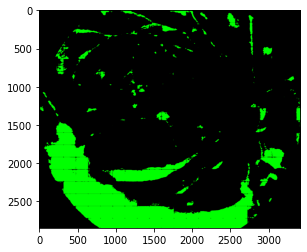

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


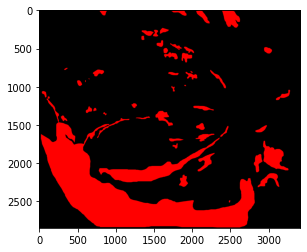

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


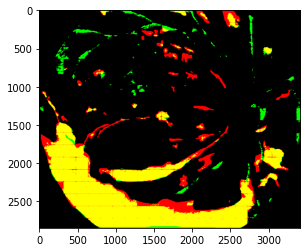

In [ ]:
DIR= "/content/drive/MyDrive/Proyectos/Sharon/Base de datos/Pruebas/Hemorragias/org/IDRiD_17.jpg"
DIR_M= "/content/drive/MyDrive/Proyectos/Sharon/Base de datos/Pruebas/Hemorragias/mask/IDRiD_17_HE.tif"

s1= "/content/drive/MyDrive/Proyectos/Sharon/Base de datos/Pruebas/Hemorragias/com/p_vgg_cbam.png"
s2= "/content/drive/MyDrive/Proyectos/Sharon/Base de datos/Pruebas/Hemorragias/com/m_vgg_cbam.png"
s3= "/content/drive/MyDrive/Proyectos/Sharon/Base de datos/Pruebas/Hemorragias/com/conv_vgg_cbam.png"

pred, mask= prediccion_final(model, DIR, DIR_M)

imagenes_comp(pred, mask, s1, s2, s3, True, True)

###2.4.3 Comparativa de mascaras

In [ ]:
def imagenes_comp(img, mask):
  img_t= np.zeros((img.shape[0], img.shape[1], 3), dtype= np.float)
  conv= np.zeros((img.shape[0], img.shape[1], 3), dtype= np.float)
  img_t[:, :, 1]= img
  #mask= np.array(mask, dtype= np.int16)

  conv[:,:,0]= mask[:,:,0]
  conv[:,:,1]= img

  return img_t, mask, conv

In [ ]:
i, m, c= imagenes_comp(img, mask)
#plt.imsave("/content/drive/MyDrive/Proyectos/Sharon/Base de datos/Pruebas/imagen_final/6_E_VGG16.png", i/255.0)
#plt.imsave("/content/drive/MyDrive/Proyectos/Sharon/Base de datos/Pruebas/imagen_final/7_E_VGG16.png", m/255.0)
plt.imsave("/content/drive/MyDrive/Proyectos/Sharon/Base de datos/Pruebas/imagen_final/2_E_VGG16.png", c/255.0)

### 2.4.3 Metricas de desempeño

In [ ]:
#from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import ImageOps
import tensorflow as tf
import numpy as np
import cv2 as cv
import PIL
import os


drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DIR= '/content/drive/MyDrive/Proyectos/Sharon/Modelos guardados/Segmentacion/17102021_E.hdf5'
model= tf.keras.models.load_model(DIR)

In [ ]:
def obtener_tensor(DIR_img, DIR_M):
  img= cv.cvtColor(cv.imread(DIR_img), cv.COLOR_BGR2RGB)
  mask= tf.keras.preprocessing.image.load_img(DIR_M)
  mask= tf.keras.preprocessing.image.img_to_array(mask)
  m= mask[:,:,0]/255

  return img, m

def prediccion_m(model, img, mostrar= True):
  img= (np.array(img).reshape(-1,320,320,3))/255.0
  val_preds = model.predict(img)
  mask = np.argmax(val_preds[0], axis=-1)
  return mask

def sen_esp(x, m):
  x= np.reshape(x, 320*320)
  m= np.reshape(m, 320*320)
  FN= 0; VP= 0; FP= 0; VN= 0  
  for i in range(len(x)):
    if x[i]== m[i] and m[i]== 0:
      VN+= 1
    elif x[i]== m[i] and m[i]== 1:
      VP+= 1
    elif x[i]!= m[i] and m[i]== 0:
      FP+= 1
    else:
      FN+= 1
  SEN= VP/((VP+FN)+1)
  ESP= VN/((VN+FP)+1)

  return SEN, ESP


def datos_entreda(ent_input_dir, ent_target_dir):
  input_img_paths = sorted(
      [
          os.path.join(ent_input_dir, fname)
          for fname in os.listdir(ent_input_dir) 
          if fname.endswith(".png")
      ]
  )

  target_img_paths = sorted(
      [
          os.path.join(ent_target_dir, fname)
          for fname in os.listdir(ent_target_dir)
          if fname.endswith(".png") and not fname.startswith(".")
      ]
  )

  return input_img_paths, target_img_paths

In [ ]:
DIR= "/content/drive/MyDrive/Proyectos/Sharon/Base de datos/Segmentacion/Validacion/img"
DIR_M= "/content/drive/MyDrive/Proyectos/Sharon/Base de datos/Segmentacion/Validacion/exu"

i, j= datos_entreda(DIR, DIR_M)
tesp= 0; tsen= 0
for t in range(len(i)):
  img, mask= obtener_tensor(i[t], j[t])
  x= prediccion_m(model, img, False)
  sen, esp= sen_esp(x, mask)
  tsen = tsen+ sen
  tesp = tesp+ esp